### Upwelled tracer

In this notebook we compare Tr mass and HCW in all 4 runs and for all tracers. Then we find the tracer and water upwelling flux ($\Phi$, $\Phi_{Tr}$) and compare it to scaling estimates from Ramos-Musalem and Allen 2019 and Howatt and Allen 2013, respectively.

* HCW all calculated with lin tracer, but shouldn't it be the same for all tracers ideally? Ideally, I think so, but some profiles will be more diffusive (if they concave) and thus, will find less upwelled water. By sticking to the linear profile we guaratee that we are counting tracer mass only on the same pool for water.

* TrMass calculated using lin tracer to find cells with upwelled water and concetration from the tracer we are studying.

CAREFUL: UNITS ARE ALL WEIRD FOR OXY, DIC, ALK!! To go from molality to molarity multiply , for example (sw = seawater)

I have converted from umol/kg to uM in the calculation for HCW, TrMass, etc.

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import xarray as xr
import matplotlib.gridspec as gspec

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [4]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

In [5]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'


state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
state = xr.open_dataset(state_file)
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [6]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

### 01 - Initial profiles

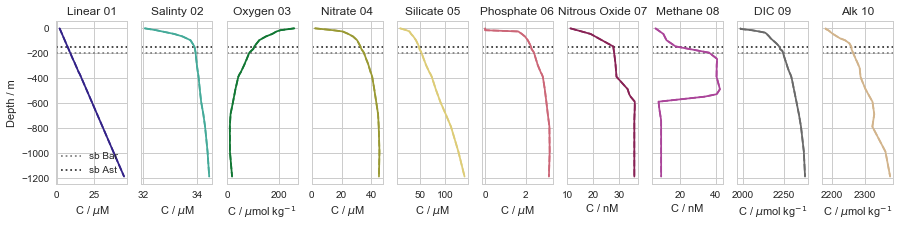

In [7]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]

        ax[ii].plot(tr_profile, Z, color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

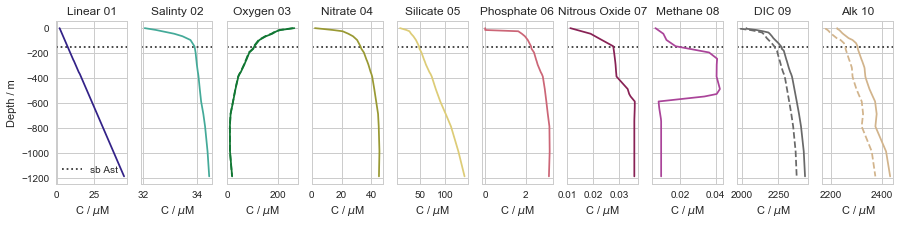

In [8]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileA],[ZA],['-']):
        with Dataset(pfile, 'r') as nbl:
        
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax[ii].plot(1E-3*tr_profile, Z, color=col,linestyle=style)
                ax[ii].set_xlabel(r'C / $\mu$M')
            
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                tr_profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                ax[ii].plot(density*tr_profile/1000, Z, color=col,linestyle=style)
                ax[ii].plot(tr_profile, Z, color=col,linestyle='--')
                ax[ii].set_xlabel(r'C / $\mu$M')
            
            else:
                ax[ii].set_xlabel(r'C / $\mu$M')
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax[ii].plot(tr_profile, Z, color=col,linestyle=style)

        ax[ii].set_title(lab)
        
        
ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Initial profiles. Profiles for both runs plotted to check they are actually the same.

#### Vertical tracer gradient

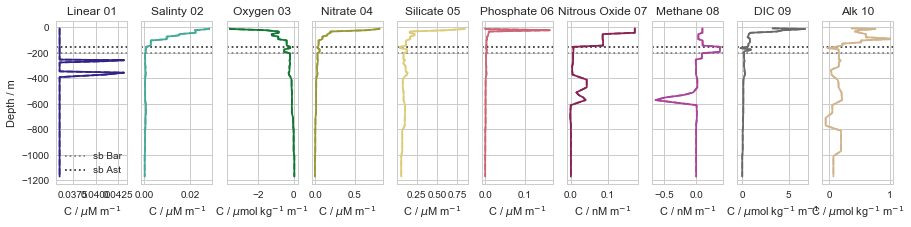

In [9]:
dTr_Ast = np.empty(len(tracers))
dTr_Bar = np.empty(len(tracers))
Tr_Ast = np.empty(len(tracers))
Tr_Bar = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast+1]/dTrdz[sb_Ast-1]
            dTr_Bar[ii] = dTrdz[sb_Bar+1]/dTrdz[sb_Bar-1]
            Tr_Ast[ii] = tr_profile[sb_Ast]
            Tr_Bar[ii] = tr_profile[sb_Bar]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM m$^{-1}$')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$ m$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M m$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Get initial concentration at shelf break

In [10]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

tracers_C = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels_C = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers_C)),tracers_C):
    for pfile,sb_array, sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B], [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]
                
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                tr_profile = density*nbl.variables[trac][0,:,10,180]/1000
                density = call_rho(0,state,slice(0,104),180,20)
                sb_array[ii] = tr_profile[sb_ind]

            else:
                tr_profile = nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]

### 02 - HCW



Canyon runs, using linear tracer

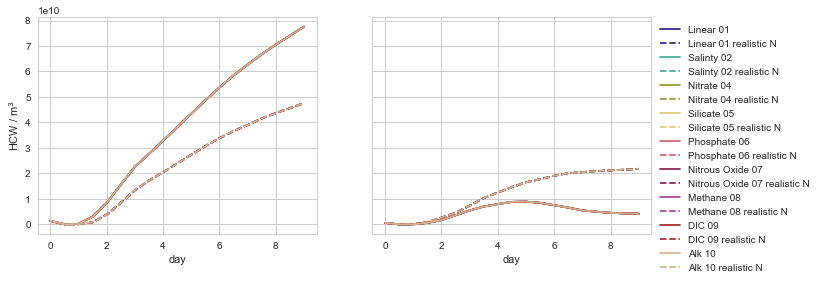

In [11]:
fig, ax = plt.subplots(1,2,figsize=(11,4), sharey=True)

tracers2 = ['Tr01','Tr02','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels2 = ['Linear 01','Salinty 02','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07',
           'Methane 08','DIC 09', 'Alk 10']
colours2 = ['#332288','#44AA99','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'brown', 'tan']

for key, col, lab in zip(tracers2, colours2, labels2):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    HCW_Ast = df_Ast['HCW']
    f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    df_Ast3 = pd.read_csv(f_Ast3)
    HCW_Ast3 = df_Ast3['HCW']
    
    ax[0].plot(np.arange(19)/2, HCW_Ast, color=col, label=lab)
    ax[0].plot(np.arange(19)/2, HCW_Ast3,'--', color=col, label=lab)
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    df_Bar = pd.read_csv(f_Bar)
    HCW_Bar = df_Bar['HCW']
    f_Bar3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    df_Bar3 = pd.read_csv(f_Bar3)
    HCW_Bar3 = df_Bar3['HCW']
   
    ax[1].plot(np.arange(19)/2, HCW_Bar, color=col, label=lab)
    ax[1].plot(np.arange(19)/2, HCW_Bar3,'--', color=col, label=lab+' realistic N')

ax[0].set_ylabel('HCW / m$^3$')
ax[0].set_xlabel('day')
ax[1].set_xlabel('day')

ax[1].legend(bbox_to_anchor=(1,1))

### 03. Upwelled Tracer - Astoria bathymetry

**Canyon runs, Astorias**

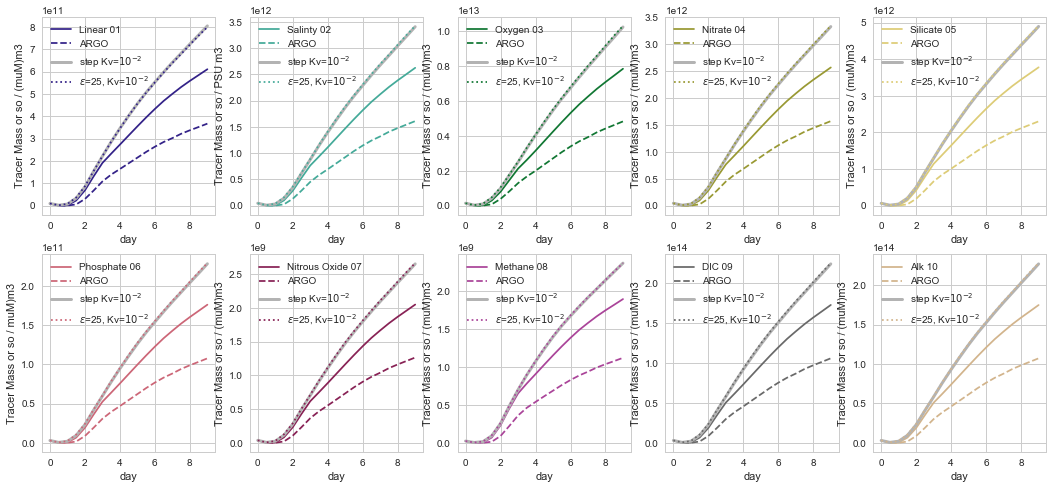

In [19]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_KV1 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_01.csv' %key)
    f_KV2 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_KV3D_AST/HCW_TrMass_%s_UPW_10TR_BF2_KV3D_AST_02.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_KV1 = pd.read_csv(f_KV1)
    df_KV2 = pd.read_csv(f_KV2)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
        TrMass_KV1 = 1E-3*df_KV1['TrMassHCW']
        TrMass_KV2 = 1E-3*df_KV2['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
        TrMass_KV1 = df_KV1['TrMassHCW']
        TrMass_KV2 = df_KV2['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='ARGO')
    ax.plot(np.arange(19)/2, TrMass_KV1,'-', color='0.7', label=r'step Kv=$10^{-2}$', linewidth=3)
    ax.plot(np.arange(19)/2, TrMass_KV2,':', color=col, label=r'$\epsilon$=25, Kv=$10^{-2}$')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



**No canyon**

In [ ]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



**Canyon effect** (Can - no Can runs)

In [ ]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
        TrMass_AstNoC = 1E-3*df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
        TrMass_AstNoC = df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW']

    ax.plot(np.arange(19)/2, TrMass_Ast-TrMass_AstNoC, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo-TrMass_ArgoNoC,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



#### 3.1 Tracer flux vs upwelling flux $\times$ C_sb (all from model output)

In [ ]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,2.5E8, 20)
ax.plot(xx,xx,'-', color='0.5')
ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df = pd.read_csv(filename)
    HCW = df['HCW'][:]
    
    filenameARGO = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    dfARGO = pd.read_csv(filenameARGO)
    HCWARGO = dfARGO['HCW'][:]
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass = 1E-3*df['TrMassHCW'][:]
        TrMassARGO = 1E-3*dfARGO['TrMassHCW'][:]
    else:
        TrMass = df['TrMassHCW'][:]
        TrMassARGO = dfARGO['TrMassHCW'][:]
    
    Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    PhiARGO = np.mean(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_stdARGO = np.std(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTrARGO = np.mean(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_stdARGO = np.std(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    error = 100*(Phi*C-PhiTr)/PhiTr
    errorARGO = 100*(PhiARGO*C-PhiTrARGO)/PhiTrARGO
    
    ax.scatter(Phi*C, PhiTr, c=col, label=lab)
    ax2.scatter(Phi*C, PhiTr, c=col, label=lab)
     
    ax.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label=lab)
    ax2.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label='ARGO')
    
    print('%s, error %1.3f percent ' %(lab, error))
    print('%s ARGO, error %1.3f percent ' %(lab, errorARGO))
ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_ylabel(r'$\Phi_{Tr}$')
ax2.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlim(0,0.12E8)
ax2.set_ylim(0,0.12E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)
print(PhiARGO)

It is reasonable to scale tracer flux $\Phi_{Tr}$ as upwelling flux $\Phi C_{sb}$ within 0.5% except for Linear (5%) and Methane ($\sim$22%) and nitrous oxide ($\sim$6%)

### 4. Upwelled tracer - Barkley bathymetries

**Canyon runs**

In [ ]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')


**Barkley shelf, no canyon**

In [ ]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
      
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')


**Canyon effect** (Can - no Can)

In [ ]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
        TrMass_AstNoC = 1E-3*df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC['TrMassHCW']
    
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
        TrMass_AstNoC = df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast-TrMass_AstNoC, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo-TrMass_ArgoNoC,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



#### 4.1 Tracer flux vs upwelling flux $\times$ C_sb (all from model output)

In [ ]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,0.7E8, 20)
ax.plot(xx,xx,'-', color='0.5')
ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    df = pd.read_csv(filename)
    HCW = df['HCW'][:]
    
    filenameARGO = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    dfARGO = pd.read_csv(filenameARGO)
    HCWARGO = dfARGO['HCW'][:]
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass = 1E-3*df['TrMassHCW'][:]
        TrMassARGO = 1E-3*dfARGO['TrMassHCW'][:]
    else:
        TrMass = df['TrMassHCW'][:]
        TrMassARGO = dfARGO['TrMassHCW'][:]
    
    Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    PhiARGO = np.mean(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_stdARGO = np.std(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTrARGO = np.mean(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_stdARGO = np.std(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    error = 100*((Phi*C)-PhiTr)/PhiTr
    errorARGO = 100*((PhiARGO*C)-PhiTrARGO)/PhiTrARGO
    
    ax.scatter(Phi*C, PhiTr, c=col, label=lab)
    ax2.scatter(Phi*C, PhiTr, c=col, label=lab)
     
    ax.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label=lab)
    ax2.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label='PATHWAYS')
    
    print('%s, error %1.3f percent ' %(lab, error))
    print('%s PATH., error %1.3f percent ' %(lab, errorARGO))
ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlim(-0.015E8,0.04E8)
ax2.set_ylim(-0.015E8,0.04E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)
print(PhiARGO)

Upwelled water flux is negative for Barkley... 

Errors are larger than for Astoria, considering only PATHWAYS: 22% linear, 17% oxygen, 6% nitrate, 40% methane, 10% silicate, 5% phosphate

### 5. Comparison to previous scalings

In [ ]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [ ]:
g = 9.81 # accel. gravity
Hs = 150 # Shelf break depth
s = 0.00230 # shelf slope 
N = 5.5E-3
f = 1.0E-4
U = 0.3
Wiso = 8900
L = 21800

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = 107397.14556475678 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))

In [ ]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,2.5E8, 20)
ax.plot(xx,xx,'-', color='0.5')
ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df = pd.read_csv(filename)
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass = 1E-3*df['TrMassHCW'][:]
    else:
        TrMass = df['TrMassHCW'][:]
    
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    error = 100*(HA2013*C-PhiTr)/PhiTr
    
    ax.scatter(HA2013*C, PhiTr, c=col, label=lab)
    ax2.scatter(HA2013*C, PhiTr, c=col, label=lab)
     
    
    print('%s, error %1.3f percent ' %(lab, error))

ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi_{HA2013} C_{sb}$')
ax2.set_ylabel(r'$\Phi_{Tr}$')
ax2.set_xlabel(r'$\Phi_{HA2013} C_{sb}$')
ax2.set_xlim(0,0.12E8)
ax2.set_ylim(0,0.12E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)

Still pretty good! Linear has smaller error and methane is the only bad one.

ARGO:

In [ ]:
# ARGO RUN
g = 9.81 # accel. gravity
Hs = 150 # Shelf break depth
s = 0.00230 # shelf slope 
N = 0.00880 # Initial at 152.5 m
f = 1.05E-4
U = 0.3
Wiso = 8900
L = 21800

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = 65720.85262122174 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))

**Barkley Runs**

In [ ]:
g = 9.81 # accel. gravity
Hs = 200 # Shelf break depth
s = 0.00454 # shelf slope 
N = 5.5E-3
f = 1.0E-4
U = 0.3
Wiso = 8300.0
L = 6400

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = -6288.967068212187 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))


Wow, look at that error! No surprise since HCW decreases after day 5 in Barkley run.

PATHWAYS:

In [ ]:
# Pahways
g = 9.81 # accel. gravity
Hs = 200 # Shelf break depth
s = 0.00454 # shelf slope 
N = 0.00469   #0.00399
f = 1.08E-4
U = 0.3
Wiso = 8300.0
L = 6400

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = 25848.25118546129 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))


For Barkley runs, the error goes down if I consider a shorter time while HCW is increasing -- days 4-6 for PATHWAYS (17%) and 4-5 for BARKLEY (26%))

### Table

In [ ]:
labels_exp = ['Astoria', 'Ast. ARGO', 'Barkley', 'Bar. Path.']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']
units = ['(muM)m3/s','PSU','(umol/kg)m3/s','(muM)m3/s','(muM)m3/s','muM)m3/s','(nM)m3/s','(nM)m3/s','(umol/kg)m3/s','(umol/kg)m3/s']


print ("\t".join(['Run and Tracer &', 
                  '$\Phi_{Tr}$/10^{6} &',
                  '$M_can$/10^{11}',
                  '$M_{can}-M_{nc}/M_{can}$ day 9'
                  '$\mathcal{M}$/10^{13} &',
                 ]))

exp_files = ['saved_calcs/pool_AST.nc',
             'saved_calcs/pool_ARGO.nc',
             'saved_calcs/pool_BAR.nc',
             'saved_calcs/pool_PATH.nc']

exp_files_BAC = ['saved_calcs/BAC_AST.nc',
                 'saved_calcs/BAC_ARGO.nc',
                 'saved_calcs/BAC_BAR.nc',
                 'saved_calcs/BAC_PATH.nc']

  
for key, tr_lab in zip(tracers,labels_tra):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    f_PathNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    df_Bar = pd.read_csv(f_Bar)
    df_Path = pd.read_csv(f_Path)
    df_BarNoC = pd.read_csv(f_BarNoC)
    df_PathNoC = pd.read_csv(f_PathNoC)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW'][:]
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW'][:]
        TrMass_AstNoC = 1E-3*df_AstNoC['TrMassHCW'][:]
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC['TrMassHCW'][:]

        TotMass_Ast = 1E-3*df_Ast['TotTrMass'][:]
        TotMass_Argo = 1E-3*df_Argo['TotTrMass'][:]
        TotMass_AstNoC = 1E-3*df_AstNoC['TotTrMass'][:]
        TotMass_ArgoNoC = 1E-3*df_ArgoNoC['TotTrMass'][:]

        TrMass_Bar = 1E-3*df_Bar['TrMassHCW'][:]
        TrMass_Path = 1E-3*df_Path['TrMassHCW'][:]
        TrMass_BarNoC = 1E-3*df_BarNoC['TrMassHCW'][:]
        TrMass_PathNoC = 1E-3*df_PathNoC['TrMassHCW'][:]

        TotMass_Bar = 1E-3*df_Bar['TotTrMass'][:]
        TotMass_Path = 1E-3*df_Path['TotTrMass'][:]
        TotMass_BarNoC = 1E-3*df_BarNoC['TotTrMass'][:]
        TotMass_PathNoC = 1E-3*df_PathNoC['TotTrMass'][:]

    
    else:
        TrMass_Ast = df_Ast['TrMassHCW'][:]
        TrMass_Argo = df_Argo['TrMassHCW'][:]
        TrMass_AstNoC = df_AstNoC['TrMassHCW'][:]
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW'][:]

        TotMass_Ast = df_Ast['TotTrMass'][:]
        TotMass_Argo = df_Argo['TotTrMass'][:]
        TotMass_AstNoC = df_AstNoC['TotTrMass'][:]
        TotMass_ArgoNoC = df_ArgoNoC['TotTrMass'][:]

        TrMass_Bar = df_Bar['TrMassHCW'][:]
        TrMass_Path = df_Path['TrMassHCW'][:]
        TrMass_BarNoC = df_BarNoC['TrMassHCW'][:]
        TrMass_PathNoC = df_PathNoC['TrMassHCW'][:]

        TotMass_Bar = df_Bar['TotTrMass'][:]
        TotMass_Path = df_Path['TotTrMass'][:]
        TotMass_BarNoC = df_BarNoC['TotTrMass'][:]
        TotMass_PathNoC = df_PathNoC['TotTrMass'][:]
    
    PhiTr_Ast = np.mean(np.array([(TrMass_Ast[ii]-TrMass_Ast[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Argo = np.mean(np.array([(TrMass_Argo[ii]-TrMass_Argo[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Bar = np.mean(np.array([(TrMass_Bar[ii]-TrMass_Bar[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Path = np.mean(np.array([(TrMass_Path[ii]-TrMass_Path[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
   
    print ("\t".join(['Astoria %s &' %(tr_lab), 
                      '%1.2f &' %(PhiTr_Ast/1E6),
                      '%1.2f &' %(TrMass_Ast[18]/1E11),
                      '%1.2f &' %(100*(TrMass_Ast[18]-TrMass_AstNoC[18])/TrMass_Ast[18]),
                      '%1.2f skl ' %(TotMass_Ast[18]/1E13),
                     ]))
    print ("\t".join(['Ast. ARGO %s &' %(tr_lab), 
                      '%1.2f &' %(PhiTr_Argo/1E6),
                      '%1.2f &' %(TrMass_Argo[18]/1E11),
                      '%1.2f &' %(100*(TrMass_Argo[18]-TrMass_ArgoNoC[18])/TrMass_Argo[18]),
                      '%1.2f skl ' %(TotMass_Argo[18]/1E13),
                     ]))
    print ("\t".join(['Barkley %s &' %(tr_lab), 
                      '%1.2f &' %(PhiTr_Bar/1E6),
                      '%1.2f &' %(TrMass_Bar[18]/1E11),
                      '%1.2f &' %(100*(TrMass_Bar[18]-TrMass_BarNoC[18])/TrMass_Bar[18]),
                      '%1.2f skl ' %(TotMass_Bar[18]/1E13),
                     ]))
    print ("\t".join(['Bar. Path. %s &' %(tr_lab), 
                      '%1.2f &' %(PhiTr_Path/1E6),
                      '%1.2f &' %(TrMass_Path[18]/1E11),
                      '%1.2f &' %(100*(TrMass_Path[18]-TrMass_PathNoC[18])/TrMass_Path[18]),
                      '%1.2f skl ' %(TotMass_Path[18]/1E13),
                     ]))
   